In [3]:
from sklearn.base import BaseEstimator
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
import pandas as pd
import collections as cl
import numpy as np


class HPClassifier(BaseEstimator):
    def __init__(self, n_Samples=None):
        super().__init__()
        self.n_Samples = n_Samples
        self.classifiers = []
        self.frequencies = []

    def fit(self, data, target):
        classifiers = []
        
        self.frequencies = cl.Counter(target)

        for nr_Index in range(self.n_Samples):
            if nr_Index != 0:
                data, target = resample(data, target, random_state=nr_Index-1)

            gaussianClassifier = GaussianNB()
            decisionClassifier = DecisionTreeClassifier()
            knnClassifier = KNeighborsClassifier(n_neighbors=1)

            gaussianClassifier.fit(data, target)
            decisionClassifier.fit(data, target)
            knnClassifier.fit(data, target)

            classifiers.append(gaussianClassifier)
            classifiers.append(decisionClassifier)
            classifiers.append(knnClassifier)

        self.classifiers = classifiers

    def predict(self, data):
        result = []
        predictions = []

        for classifier in self.classifiers:
            prediction = classifier.predict(data)
            predictions.append(prediction)

        dataFrame = pd.DataFrame(data=predictions)
        data = np.asarray(data)

        for index in dataFrame.columns:
            column = dataFrame[index]
            choice = cl.Counter(column).most_common(1)[0][0]
            self.getBetterChoice(column)
            result.append(choice)

        return np.asarray(result)

    def getBetterChoice(self, column):
        frequencies = cl.Counter(column).items()
        betterFrequency = 0
        better = None
        
        for key, value in frequencies:
            if(value > betterFrequency):
                better = key
                betterFrequency = value
            elif(value == betterFrequency):
                for selfKey, selfValue in self.frequencies.most_common():
                    if(selfKey == better):
                        break
                    if(selfKey == key):
                        better = key
                        betterFrequency = value

        return better

In [4]:
from sklearn import datasets
from scipy import stats
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
import numpy as np


def Get_Stats(data, target, classifier, grade={'classifier__n_estimators': [10, 25, 50, 100]}):
    scaler = StandardScaler()

    pipeline = Pipeline([("scaler", scaler), ('classifier', classifier)])

    grade = grade

    gridSearch = GridSearchCV(pipeline, param_grid=grade,
                              scoring='accuracy', cv=4)

    cv = RepeatedStratifiedKFold(
        n_splits=10, n_repeats=3, random_state=36851234)

    scores = cross_val_score(
        gridSearch, data, target, scoring='accuracy', cv=cv, n_jobs=-1)

    mean = scores.mean()
    std = scores.std()
    lower, upper = stats.norm.interval(
        0.95, loc=mean, scale=std / np.sqrt(len(scores)))

    return [scores, mean, std, lower, upper]


def Get_Digits():
    digits = datasets.load_digits()
    target = digits.target
    data = digits.data
    return data, target


def Get_Wine():
    wine = datasets.load_wine()
    target = wine.target
    data = wine.data
    return data, target


def Get_Breast_Cancer():
    cancer = datasets.load_breast_cancer()
    target = cancer.target
    data = cancer.data
    return data, target

def Calculate_Digits_Classifiers():
    data, target = Get_Digits()
    classifier = BaggingClassifier()
    baggingResults = Get_Stats(data, target, classifier)

    data, target = Get_Digits()
    classifier = AdaBoostClassifier()
    adaBoostResults = Get_Stats(data, target, classifier)

    data, target = Get_Digits()
    classifier = RandomForestClassifier()
    randomForestResults = Get_Stats(data, target, classifier)

    data, target = Get_Digits()
    classifier = HPClassifier()
    hpResults = Get_Stats(data, target, classifier, {
                          'classifier__n_Samples': [1, 3, 5, 7]})

    print(baggingResults[1:])
    print(adaBoostResults[1:])
    print(randomForestResults[1:])
    print(hpResults[1:])

    return [baggingResults, adaBoostResults, randomForestResults, hpResults]


def Calculate_Wine_Classifiers():
    data, target = Get_Wine()
    classifier = BaggingClassifier()
    baggingResults = Get_Stats(data, target, classifier)

    data, target = Get_Wine()
    classifier = AdaBoostClassifier()
    adaBoostResults = Get_Stats(data, target, classifier)

    data, target = Get_Wine()
    classifier = RandomForestClassifier()
    randomForestResults = Get_Stats(data, target, classifier)

    data, target = Get_Wine()
    classifier = HPClassifier()
    hpResults = Get_Stats(data, target, classifier, {
                          'classifier__n_Samples': [1, 3, 5, 7]})

    print(baggingResults[1:])
    print(adaBoostResults[1:])
    print(randomForestResults[1:])
    print(hpResults[1:])

    return [baggingResults, adaBoostResults, randomForestResults, hpResults]


def Calculate_Breast_Cancer_Classifiers():
    data, target = Get_Breast_Cancer()
    classifier = BaggingClassifier()
    baggingResults = Get_Stats(data, target, classifier)

    data, target = Get_Breast_Cancer()
    classifier = AdaBoostClassifier()
    adaBoostResults = Get_Stats(data, target, classifier)

    data, target = Get_Breast_Cancer()
    classifier = RandomForestClassifier()
    randomForestResults = Get_Stats(data, target, classifier)

    data, target = Get_Breast_Cancer()
    classifier = HPClassifier()
    hpResults = Get_Stats(data, target, classifier, {
                          'classifier__n_Samples': [1, 3, 5, 7]})

    print(baggingResults[1:])
    print(adaBoostResults[1:])
    print(randomForestResults[1:])
    print(hpResults[1:])

    return [baggingResults, adaBoostResults, randomForestResults, hpResults]


def Get_Accuracies(results):
    accuracies = []

    for item in results:
        accuracies.append(item[0])

    return accuracies


def Get_Boxplot(results, names=["Bagging", "AdaBoost", "Random Forest", "HP"]):
    auxResult = []

    for nr_Index, ds_Name in enumerate(names):
        for result in results[nr_Index]:
            auxResult.append((result, ds_Name))

    data = pd.DataFrame(auxResult, columns=["scores", "names"])

    sns.boxplot(x='names', y='scores', data=data, showmeans=True)


# digitsResults = Calculate_Digits_Classifiers()
# wineResults = Calculate_Wine_Classifiers()
cancerResults = Calculate_Breast_Cancer_Classifiers()


[0.9560776942355887, 0.023855427762735425, 0.9475412959057979, 0.9646140925653796]
[0.967784043441938, 0.023573124466449304, 0.9593486641930407, 0.9762194226908354]
[0.958970342522974, 0.02329410172085313, 0.9506348084465536, 0.9673058765993944]
[0.956641604010025, 0.02344014467731396, 0.9482538100931184, 0.9650293979269315]


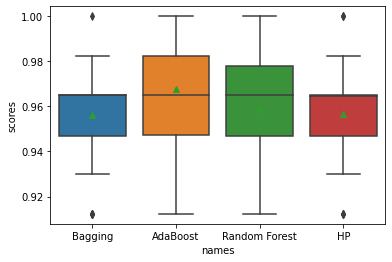

In [5]:
# Get_Boxplot(Get_Accuracies(digitsResults))
# Get_Boxplot(Get_Accuracies(wineResults))
Get_Boxplot(Get_Accuracies(cancerResults))

In [7]:
from scipy.stats import ttest_rel, wilcoxon

newResults = cancerResults

result = []

names = ["Bagging", "AdaBoost", "Random Forest", "HP"]

for i, primaryResult in enumerate(newResults):
    line = []

    for j, secundaryResult in enumerate(newResults):
        if(i > j):
            _, pTest = ttest_rel(primaryResult[0], secundaryResult[0])
            line.append(names[i] + ' | ' + names[j] + ': ' + str(pTest))
        elif(j > i):
            _, pWilcoxon = wilcoxon(primaryResult[0], secundaryResult[0])
            line.append(names[i] + ' | ' + names[j] + ': ' + str(pWilcoxon))
        else:
            line.append(names[i])

    result.append(line)

print(result)

[['Bagging', 'Bagging | AdaBoost: 0.002780676224323174', 'Bagging | Random Forest: 0.5014744073080681', 'Bagging | HP: 0.980942332419318'], ['AdaBoost | Bagging: 0.0017707357279075314', 'AdaBoost', 'AdaBoost | Random Forest: 0.01785429278938296', 'AdaBoost | HP: 0.013422694398843542'], ['Random Forest | Bagging: 0.38472921447999464', 'Random Forest | AdaBoost: 0.022260880075553335', 'Random Forest', 'Random Forest | HP: 0.6904445201526377'], ['HP | Bagging: 0.9072798443820607', 'HP | AdaBoost: 0.012181744931508524', 'HP | Random Forest: 0.5743840707137526', 'HP']]
0.5743840707137526 0.6904445201526377
